In [1]:
import numpy as np
import seaborn as sns
import os
import nibabel as nib
import matplotlib.pyplot as plt
#%matplotlib notebook
sns.set_style("whitegrid", {'axes.grid' : False})
import os
import glob
import sys
import random
from argparse import ArgumentParser

# third-party imports
import tensorflow as tf
import numpy as np
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
#from keras.utils import multi_gpu_model 

# project imports
os.chdir('/Users/chalvidalm/Documents/3A OMA/Projets OMA/Projet/voxelmorph-master/src')
import datagenerators
import networks
import losses

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


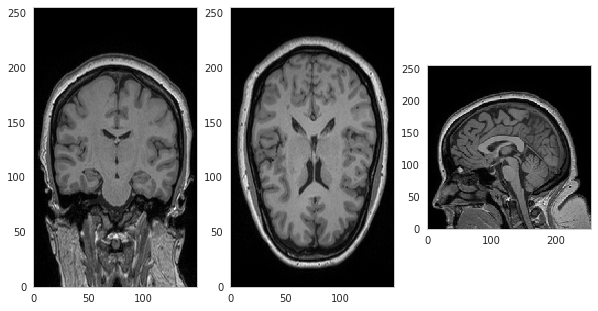

In [2]:
epi_img = nib.load('/Users/chalvidalm/Documents/3A OMA/Projets OMA/Projet/guest-20181031_072008/100_Guys/T1/NIfTI/IXI100-Guys-0747-T1.nii.gz')
epi_img_data = epi_img.get_fdata()

def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(10,6))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        
slice_0 = epi_img_data[125, :, :].T
slice_1 = epi_img_data[:, 130, :].T
slice_2 = epi_img_data[:, :, 75]
show_slices([slice_0,slice_1,slice_2])

In [3]:
os.chdir('/Users/chalvidalm/Documents/3A OMA/Projets OMA/Projet/voxelmorph-master/ext/neuron')
import neuron.callbacks as nrn_gen
os.chdir('/Users/chalvidalm/Documents/3A OMA/Projets OMA/Projet/voxelmorph-master/')

In [4]:
def train(data_dir,
          atlas_file, 
          model,
          model_dir,
          gpu_id,
          lr,
          nb_epochs,
          reg_param,
          steps_per_epoch,
          batch_size,
          load_model_file,
          data_loss,
          initial_epoch=0):
    """
    model training function
    :param data_dir: folder with npz files for each subject.
    :param atlas_file: atlas filename. So far we support npz file with a 'vol' variable
    :param model: either vm1 or vm2 (based on CVPR 2018 paper)
    :param model_dir: the model directory to save to
    :param gpu_id: integer specifying the gpu to use
    :param lr: learning rate
    :param n_iterations: number of training iterations
    :param reg_param: the smoothness/reconstruction tradeoff parameter (lambda in CVPR paper)
    :param steps_per_epoch: frequency with which to save models
    :param batch_size: Optional, default of 1. can be larger, depends on GPU memory and volume size
    :param load_model_file: optional h5 model file to initialize with
    :param data_loss: data_loss: 'mse' or 'ncc
    """

    # load atlas from provided files. The atlas we used is 160x192x224.
    atlas_vol = np.load(atlas_file)['vol'][np.newaxis, ..., np.newaxis]
    vol_size = atlas_vol.shape[1:-1] 
    # prepare data files
    # for the CVPR and MICCAI papers, we have data arranged in train/validate/test folders
    # inside each folder is a /vols/ and a /asegs/ folder with the volumes
    # and segmentations. All of our papers use npz formated data.
    train_vol_names = glob.glob(os.path.join(data_dir, '*.npz'))
    random.shuffle(train_vol_names)  # shuffle volume list
    assert len(train_vol_names) > 0, "Could not find any training data"

    # UNET filters for voxelmorph-1 and voxelmorph-2,
    # these are architectures presented in CVPR 2018
    nf_enc = [16, 32, 32, 32]
    if model == 'vm1':
        nf_dec = [32, 32, 32, 32, 8, 8]
    elif model == 'vm2':
        nf_dec = [32, 32, 32, 32, 32, 16, 16]
    else: # 'vm2double': 
        nf_enc = [f*2 for f in nf_enc]
        nf_dec = [f*2 for f in [32, 32, 32, 32, 32, 16, 16]]

    assert data_loss in ['mse', 'cc', 'ncc'], 'Loss should be one of mse or cc, found %s' % data_loss
    if data_loss in ['ncc', 'cc']:
        data_loss = losses.NCC().loss        

    # prepare model folder
    if not os.path.isdir(model_dir):
        os.mkdir(model_dir)

    # GPU handling
    gpu = '/gpu:%d' % 0 # gpu_id
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    set_session(tf.Session(config=config))

    # prepare the model
    with tf.device(gpu):
        # prepare the model
        # in the CVPR layout, the model takes in [image_1, image_2] and outputs [warped_image_1, flow]
        # in the experiments, we use image_2 as atlas
        model = networks.cvpr2018_net(vol_size, nf_enc, nf_dec)

        # load initial weights
        if load_model_file is not None:
            print('loading', load_model_file)
            model.load_weights(load_model_file)

        # save first iteration
        model.save(os.path.join(model_dir, '%02d.h5' % initial_epoch))

    # data generator
    nb_gpus = len(gpu_id.split(','))
    assert np.mod(batch_size, nb_gpus) == 0, \
        'batch_size should be a multiple of the nr. of gpus. ' + \
        'Got batch_size %d, %d gpus' % (batch_size, nb_gpus)

    train_example_gen = datagenerators.example_gen(train_vol_names, batch_size=batch_size)
    atlas_vol_bs = np.repeat(atlas_vol, batch_size, axis=0)
    cvpr2018_gen = datagenerators.cvpr2018_gen(train_example_gen, atlas_vol_bs, batch_size=batch_size)

    # prepare callbacks
    save_file_name = os.path.join(model_dir, '{epoch:02d}.h5')

    # fit generator
    with tf.device(gpu):

        # multi-gpu support
        if nb_gpus > 1:
            save_callback = nrn_gen.ModelCheckpointParallel(save_file_name)
            mg_model = multi_gpu_model(model, gpus=nb_gpus)
        
        # single-gpu
        else:
            save_callback = ModelCheckpoint(save_file_name)
            mg_model = model

        # compile
        mg_model.compile(optimizer=Adam(lr=lr), 
                         loss=[data_loss, losses.Grad('l2').loss],
                         loss_weights=[1.0, reg_param])
            
        # fit
        mg_model.fit_generator(cvpr2018_gen, 
                               initial_epoch=initial_epoch,
                               epochs=nb_epochs,
                               callbacks=[save_callback],
                               steps_per_epoch=steps_per_epoch,
                               verbose=1)


In [ ]:
train(data_dir='/Users/chalvidalm/Documents/3A OMA/Projets OMA/Projet/voxelmorph-master/data',
      atlas_file='/Users/chalvidalm/Documents/3A OMA/Projets OMA/Projet/voxelmorph-master/data/atlas_norm.npz', 
      model='vm1',
      model_dir='/Users/chalvidalm/Documents/3A OMA/Projets OMA/Projet/test vm',
      gpu_id=str(0),
      lr=0.0001,
      nb_epochs=1,
      reg_param=0.01,
      steps_per_epoch=1,
      batch_size=1,
      load_model_file=None,
      data_loss='mse',
      initial_epoch=0)

"""
model training function
:param data_dir: folder with npz files for each subject.
:param atlas_file: atlas filename. So far we support npz file with a 'vol' variable
:param model: either vm1 or vm2 (based on CVPR 2018 paper)
:param model_dir: the model directory to save to
:param gpu_id: integer specifying the gpu to use
:param lr: learning rate
:param n_iterations: number of training iterations
:param reg_param: the smoothness/reconstruction tradeoff parameter (lambda in CVPR paper)
:param steps_per_epoch: frequency with which to save models
:param batch_size: Optional, default of 1. can be larger, depends on GPU memory and volume size
:param load_model_file: optional h5 model file to initialize with
:param data_loss: data_loss: 'mse' or 'ncc
"""

Epoch 1/1


Exception in thread Thread-5:
Traceback (most recent call last):
  File "//anaconda/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "//anaconda/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "//anaconda/lib/python3.5/site-packages/keras/utils/data_utils.py", line 568, in data_generator_task
    generator_output = next(self._generator)
  File "/Users/chalvidalm/Documents/3A OMA/Projets OMA/Projet/voxelmorph-master/src/datagenerators.py", line 19, in cvpr2018_gen
    X = next(gen)[0]
  File "/Users/chalvidalm/Documents/3A OMA/Projets OMA/Projet/voxelmorph-master/src/datagenerators.py", line 81, in example_gen
    X = load_volfile(vol_names[idx])
  File "/Users/chalvidalm/Documents/3A OMA/Projets OMA/Projet/voxelmorph-master/src/datagenerators.py", line 142, in load_volfile
    X = np.load(datafile)['vol_data']
  File "//anaconda/lib/python3.5/site-packages/numpy/lib/npyio.py", line 255, in __getitem__
  

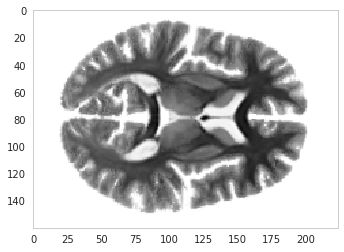

In [33]:
img = np.load('/Users/chalvidalm/Documents/3A OMA/Projets OMA/Projet/voxelmorph-master/data/atlas_norm.npz')
dir(img.files)
plt.imshow(img['vol'][:,90,:])

In [29]:
img['vol'].shape

(160, 192, 224)

In [27]:
img['vol']

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.